In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loading Dataset 'train_terms.tsv' which contains the list of annotated terms (functions) for the proteins. We will extract the labels aka GO term ID and create a label dataframe for the protein embeddings.

Gene Ontology(GO)is a controlled vocabulary that describes the functions of genes and gene products. It is constantly being updated as new information becomes available.

In [2]:
train_terms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
print(train_terms.shape)

(5363863, 3)


train_terms dataframe is composed of 3 columns and 5363863 entries. We can see all 3 dimensions of our dataset below

In [3]:
train_terms.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


If we look at the first entry of train_terms.tsv, we can see that it contains protein id(A0A009IHW8), the GO term(GO:0008152) and its aspect(BPO)

**Overview of train_sequence.fasta**

In bioinformatics and biochemistry, the FASTA format is a text-based format for representing either nucleotide sequences or amino acid (protein) sequences, in which nucleotides or amino acids are represented using single-letter codes.

In [4]:
with open("/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta", "r") as file:
    fasta_100 = file.readlines()[:100]

In [5]:
fasta_100[:10]

['>P20536 sp|P20536|UNG_VACCC Uracil-DNA glycosylase OS=Vaccinia virus (strain Copenhagen) OX=10249 GN=UNG PE=1 SV=1\n',
 'MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIPDKFFIQLKQPLRNK\n',
 'RVCVCGIDPYPKDGTGVPFESPNFTKKSIKEIASSISRLTGVIDYKGYNLNIIDGVIPWN\n',
 'YYLSCKLGETKSHAIYWDKISKLLLQHITKHVSVLYCLGKTDFSNIRAKLESPVTTIVGY\n',
 'HPAARDRQFEKDRSFEIINVLLELDNKVPINWAQGFIY\n',
 '>O73864 sp|O73864|WNT11_DANRE Protein Wnt-11 OS=Danio rerio OX=7955 GN=wnt11 PE=2 SV=1\n',
 'MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKLLDGLVPDQQQLCKR\n',
 'NLELMHSIVRAARLTKSACTSSFSDMRWNWSSIESAPHFTPDLAKGTREAAFVVSLAAAV\n',
 'VSHAIARACASGDLPSCSCAAMPSEQAAPDFRWGGCGDNLRYYGLQMGSAFSDAPMRNRR\n',
 'SGPQDFRLMQLHNNAVGRQVLMDSLEMKCKCHGVSGSCSVKTCWKGLQDISTISADLKSK\n']

Understand the fasta header: https://www.uniprot.org/help/fasta-headers

**Loading the protein embeddings**

We will now load the pre calculated protein embeddings created by Sergei Fironov using the Rost Lab's T5 protein language model.

(https://www.kaggle.com/datasets/sergeifironov/t5embeds)

The protein embeddings to be used for training are recorded in train_embeds.npy and the corresponding protein ids are available in train_ids.npy.

First, we will load the protein ids of the protein embeddings in the train dataset contained in train_ids.npy into a numpy array.

T5 (Text-To-Text Transfer Transformer) is a versatile transformer-based model capable of various natural language processing tasks. In the context of protein embeddings, T5 can be fine-tuned to learn protein representations by treating the amino acid sequences as text inputs.

Each protein's amino acid sequence is considered as a "sentence" or "text," and the corresponding protein function(s) serve as the "labels" or "categories." By fine-tuning the T5 model with labeled protein sequences, we can train it to predict the function(s) of unseen proteins based on their sequences.

In [6]:
train_protein_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
print(train_protein_ids.shape)

(142246,)


In [7]:
train_protein_ids[:5]

array(['P20536', 'O73864', 'O95231', 'A0A0B4J1F4', 'P54366'], dtype='<U10')

After loading the files as numpy arrays, we will convert them into Pandas dataframe.

Each protein embedding is a vector of length 1024. We create the resulting dataframe such that there are 1024 columns to represent the values in each of the 1024 places in the vector.

In [8]:
train_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

(142246, 1024)


In [9]:
train_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


In [10]:
train_terms.shape

(5363863, 3)

In [11]:
train_terms['term'].nunique()

31466

Plotting the most frequent terms

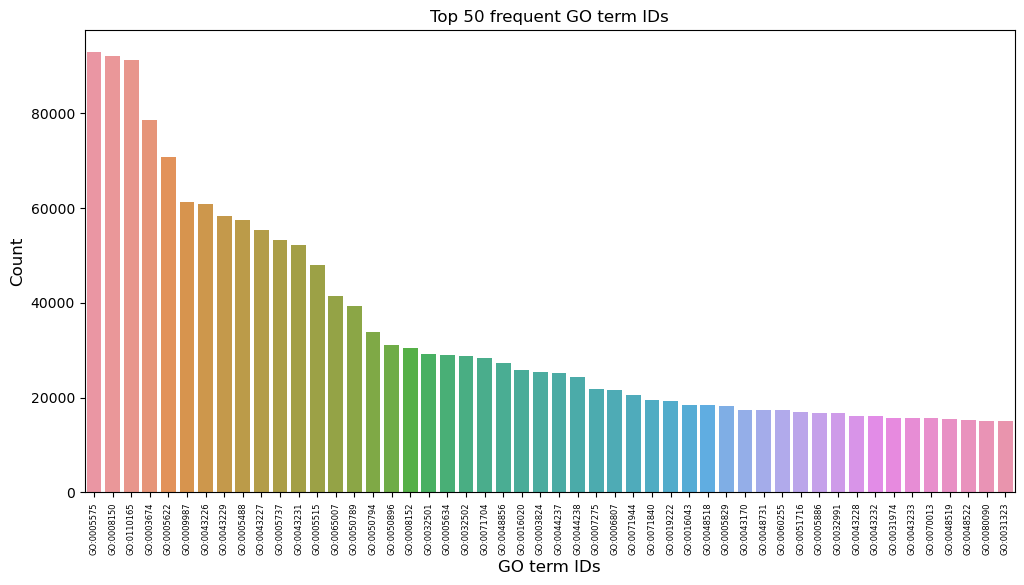

In [12]:
# Select first 50 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:50]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 50 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [13]:
train_terms.term.value_counts()

GO:0005575    92912
GO:0008150    92210
GO:0110165    91286
GO:0003674    78637
GO:0005622    70785
              ...  
GO:0031772        1
GO:0042324        1
GO:0031771        1
GO:0051041        1
GO:0102628        1
Name: term, Length: 31466, dtype: int64

Using the most common GO term ID we will create a new dataframe by filtering the train terms

**Classifing proteins using random forest**

In [14]:
train_terms.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [15]:
# list of 10 most common proteins in the dataset
no_labels = 10
top_10_label_list = train_terms.value_counts('term', ascending=False).index[:no_labels].tolist()

In [16]:
top_10_label_list

['GO:0005575',
 'GO:0008150',
 'GO:0110165',
 'GO:0003674',
 'GO:0005622',
 'GO:0009987',
 'GO:0043226',
 'GO:0043229',
 'GO:0005488',
 'GO:0043227']

In [17]:
# if 'term' in 'train_terms' df is not in list then assign value '11' (for other)
train_terms['label'] = train_terms['term'].apply(lambda x: top_10_label_list.index(x) if x in top_10_label_list else 11)
train_terms.head()

,EntryID,term,aspect,label
0,A0A009IHW8,GO:0008152,BPO,11
1,A0A009IHW8,GO:0034655,BPO,11
2,A0A009IHW8,GO:0072523,BPO,11
3,A0A009IHW8,GO:0044270,BPO,11
4,A0A009IHW8,GO:0006753,BPO,11


In [18]:
# create an empty series of required size for storing the labels
# train_labels = np.zeros((train_protein_ids.shape[0], 1))
train_protein_ids_df = pd.DataFrame(train_protein_ids, columns=['EntryID'])
train_terms_label_agg = train_terms.groupby('EntryID')['label'].agg(lambda x: list(set(x))).reset_index()

In [19]:
label_df = pd.merge(train_protein_ids_df, train_terms_label_agg, on='EntryID', how='inner')
# label_df = list(label_df.loc[:,'label'])

Proteins often have multiple functions or can be involved in various biological processes. In this case, we can use multi-label classification, where a protein may be associated with multiple function labels. The T5 model can be fine-tuned to handle multi-label tasks, predicting several functions simultaneously for a given protein sequence.

In [20]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(label_df['label'])

MultiLabelBinarizer()

In [21]:
# transform label df into multilabel binary dataframe
binary_matrix = mlb.transform(label_df['label'])
binary_df = pd.DataFrame(binary_matrix, columns=mlb.classes_)
binary_df.head()

,0,1,2,3,4,5,6,7,8,9,11
0,0,1,0,1,0,1,0,0,1,0,1
1,1,1,1,1,0,1,0,0,1,0,1
2,1,1,1,1,1,0,1,1,1,1,1
3,1,1,1,1,0,1,1,0,0,1,1
4,1,0,1,1,1,0,1,1,1,1,1


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

In [23]:
rf_classifier = RandomForestClassifier(n_estimators=3)
multi_target_classifier = MultiOutputClassifier(rf_classifier)

In [24]:
multi_target_classifier.fit(train_df, binary_df)

MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=3))

In [25]:
import pickle
with open('multi_target_classifier_model.pkl', 'wb') as file:
    pickle.dump(multi_target_classifier, file)

In [26]:
train_df.shape

(142246, 1024)

In [27]:
binary_df.shape

(142246, 11)

**Submission**

For submission we will use the protein embeddings of the test data created by Sergei Fironov using the Rost Lab's T5 protein language model.

convert to submission: 141865 x 1500

why 1500?? last step output binary is 1500?

In [28]:
test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')

# Convert test_embeddings to dataframe
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141865, 1024)


The test_df is composed of 1024 columns and 141865 entries. We can see all 1024 dimensions(results will be truncated since column length is too long) of our dataset by printing out the first 5 entries using the following code:

In [29]:
test_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.054705,0.063420,-0.015320,-0.016506,0.042195,0.021592,-0.118535,-0.063298,-0.046146,-0.102311,...,-0.019581,-0.043712,-0.072322,0.002404,0.018459,-0.047278,0.012195,-0.043319,0.036009,0.063093
1,0.090373,0.089842,-0.023887,-0.011446,0.051465,0.020982,-0.110989,-0.066646,-0.041259,-0.087551,...,-0.024399,-0.041957,-0.066329,0.006856,0.028449,-0.053758,0.009699,-0.053350,0.019644,0.079630
2,0.043588,0.039572,-0.014332,-0.011769,0.045109,0.015847,-0.103339,-0.047735,-0.022730,-0.091452,...,-0.029648,-0.037944,-0.046043,0.003603,0.018028,-0.030746,0.003671,-0.044464,0.030974,0.040322
3,0.055668,0.049560,-0.019646,-0.006977,0.039897,0.021177,-0.108079,-0.047191,-0.031517,-0.100057,...,-0.023210,-0.041704,-0.048440,0.006088,0.020110,-0.046751,-0.006635,-0.041455,0.016683,0.057030
4,0.022637,0.014306,-0.002696,-0.034456,0.034854,0.020822,-0.114046,-0.050019,-0.026491,-0.097928,...,-0.019185,-0.032108,-0.051394,0.008448,0.015208,-0.037987,0.030977,-0.042407,0.041232,0.047161


We will now use the model to make predictions on the test embeddings.

In [30]:
predictions =  multi_target_classifier.predict_proba(test_df)

In [31]:
predictions

[array([[0.        , 1.        ],
        [0.06666667, 0.93333333],
        [0.        , 1.        ],
        ...,
        [1.        , 0.        ],
        [0.66666667, 0.33333333],
        [1.        , 0.        ]]),
 array([[0.        , 1.        ],
        [0.13095238, 0.86904762],
        [0.27777778, 0.72222222],
        ...,
        [0.66666667, 0.33333333],
        [0.66666667, 0.33333333],
        [0.        , 1.        ]]),
 array([[0.        , 1.        ],
        [0.2       , 0.8       ],
        [0.        , 1.        ],
        ...,
        [0.33333333, 0.66666667],
        [0.66666667, 0.33333333],
        [0.33333333, 0.66666667]]),
 array([[0.        , 1.        ],
        [0.        , 1.        ],
        [0.        , 1.        ],
        ...,
        [0.33333333, 0.66666667],
        [0.66666667, 0.33333333],
        [0.33333333, 0.66666667]]),
 array([[0.        , 1.        ],
        [0.11111111, 0.88888889],
        [0.55555556, 0.44444444],
        ...,
        [

In [32]:
len(predictions)

11

In [33]:
df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')

In [34]:
df_submission['Protein Id'] = test_protein_ids
df_submission['GO Term Id'] = 'GO:0005575'
df_submission['Prediction'] = predictions[:,1]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
df_submission

In [ ]:
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")